# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season 1:winter, 2:spring, 3:summer, 4:fall
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

# Part 0: Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit,train_test_split
!pip install xgboost
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction import text
from nltk.stem.porter import *
import spacy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

data_bike = pd.read_csv('bike-sharing-hourly.csv')

## PART I: Exploratory Data Analysis

Look at the data

In [3]:
data_bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Check for missing values

In [4]:
# check for missing values
data_bike.isnull().sum() # no missing values

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
# Ensuring data quality (correctness, consistency, missing values, outliers...).
# Check for outliers
data_bike.describe(include='all')


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,NaN,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8690.0000,NaN,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,NaN,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,NaN,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,NaN,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,NaN,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000


In [6]:
data_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [7]:
# check for outliers with the IQR method
numeric_columns = data_bike.select_dtypes(include=np.number).columns
Q1 = data_bike[numeric_columns].quantile(0.25)
Q3 = data_bike[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = (data_bike[numeric_columns] < (Q1 - 1.5 * IQR)) | (data_bike[numeric_columns] > (Q3 + 1.5 * IQR))
outliers.sum()


instant          0
season           0
yr               0
mnth             0
hr               0
holiday        500
weekday          0
workingday       0
weathersit       3
temp             0
atemp            0
hum             22
windspeed      342
casual        1192
registered     680
cnt            505
dtype: int64

In [8]:
data_bike.shape

(17379, 17)

In [9]:
# Check for duplicates
data_bike.duplicated().sum() # no duplicates

0

In [10]:
# Check for data types
data_bike.dtypes

# dteday is object, we need to convert it to datetime
data_bike['dteday'] = pd.to_datetime(data_bike['dteday'])

# yr is 0 for 2011 and 1 for 2012, we need to convert it to category
# data_bike['yr'] = data_bike['yr'].astype('category')

In [11]:
# check for unique values
pd.DataFrame({'unique_values': data_bike.nunique(), 'data_type': data_bike.dtypes})

# season, yr, mnth, hr, holiday, weekday, workingday, weathersit should be categories or one hot encoded

,unique_values,data_type
instant,17379,int64
dteday,731,datetime64[ns]
season,4,int64
yr,2,int64
mnth,12,int64
hr,24,int64
holiday,2,int64
weekday,7,int64
workingday,2,int64
weathersit,4,int64


In [12]:
formatted_corr = data_bike.corr().round(2)

# heatmap using Plotly
fig = px.imshow(formatted_corr,
                text_auto=True,
                color_continuous_scale='RdBu_r', 
                aspect="auto", 
                labels=dict(x="Feature", y="Feature", color="Correlation"),
                )

# Enhancing the layout for better aesthetics
fig.update_layout(
    title='Feature Correlation Matrix',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(tickmode='linear'),
    xaxis_title="Features",
    yaxis_title="Features",
    coloraxis_colorbar=dict(title='Correlation', ticks='outside'),
)

# Adding gridlines for better readability
fig.update_xaxes(side="top")

fig.show()


In [13]:
# Visualize the distribution of the target variable
fig = px.histogram(data_bike, x='cnt', title='Distribution of the target variable')
fig.show()


In [14]:
# box plot for the distribution of the target variable by season in plotly
fig = px.box(data_bike, 
             x=data_bike['season'].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'}),
             y='cnt', title='Distribution of the target variable by season')
fig.show()


In [15]:
# violin plot for the distribution of the target variable by season in plotly
fig = px.violin(data_bike, x=data_bike['season'].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'}), 
                y='cnt', 
                box=True, 
                title='Distribution of the target variable by season'
                )
fig.show()

In [16]:
# code copied from the plotly examples

fig = go.Figure()

fig.add_trace(go.Violin(x=data_bike['season'][data_bike['yr']==0].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'}),
                        y=data_bike['cnt'][data_bike['yr']==0],
                        legendgroup='2011', scalegroup='2011', name='2011',
                        side='negative',
                        line_color='blue')
             )
fig.add_trace(go.Violin(x=data_bike['season'][data_bike['yr']==1].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'}),
                        y=data_bike['cnt'][data_bike['yr']==1],
                        legendgroup='2012', scalegroup='2012', name='2012',
                        side='positive',
                        line_color='orange')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.update_xaxes(range=[-0.4, 3.5])
fig.show()


## Feature engineering


In [17]:
data_bike=data_bike.sort_values(by='dteday',ascending=False)

In [18]:
#creating a new column for the hours in the day that we have light, assuming that sun rises at 6 and sets at 20.

data_bike['day_light'] = data_bike['hr'].apply(lambda x: 1 if (x > 6 and x < 20) else 0)

In [19]:
# creating new column for temperatures too cold and too hot. We drop the atemp column

data_bike['temp_cold'] = (data_bike['temp']*41).apply(lambda x: 1 if x < 12 else 0)

data_bike['temp_hot'] = (data_bike['temp']*41).apply(lambda x: 1 if x > 25 else 0)



In [20]:
#creating a new column for days with high windspeed

w=(data_bike['windspeed']*67)

fig = px.histogram(data_bike, x=w, title='Distribution of the target variable')
fig.show()

data_bike['high_windspeed'] = (data_bike['windspeed']*67).apply(lambda x: 1 if x >19  else 0)

In [21]:
#creating a new columns for days with bad weather

data_bike['bad_weather'] = data_bike['weathersit'].apply(lambda x: 1 if x > 2  else 0)

In [22]:
corr=data_bike.corr()

fig = px.imshow(corr,
                text_auto=True,
                color_continuous_scale='RdBu_r', 
                aspect="auto", 
                labels=dict(x="Feature", y="Feature", color="Correlation"),
                )

fig.show()


In [23]:
#creating new interactions between the variables

data_bike['temp_daylight'] = data_bike['temp']*data_bike['day_light']

data_bike['temp_humidity']= data_bike['temp']*data_bike['hum']

data_bike['temp_windspeed']= data_bike['temp']*data_bike['windspeed']

data_bike['temp_weathersit']= data_bike['temp']*data_bike['weathersit']

data_bike['temp_holiday']= data_bike['temp']*data_bike['holiday']

data_bike['temp_workingday']= data_bike['temp']*data_bike['workingday']

data_bike['temp_season']= data_bike['temp']*data_bike['season']

data_bike['temp_hr']= data_bike['temp']*data_bike['hr']

data_bike['holiday_weekday']= data_bike['holiday']*data_bike['weekday']

data_bike['holiday_weathersit']= data_bike['holiday']*data_bike['weathersit']

data_bike['holiday_hum']= data_bike['holiday']*data_bike['hum']

data_bike['holiday_windspeed']= data_bike['holiday']*data_bike['windspeed']

data_bike['holiday_daylight']= data_bike['holiday']*data_bike['day_light']

data_bike['holiday_season']= data_bike['holiday']*data_bike['season']

data_bike['holiday_hr']= data_bike['holiday']*data_bike['hr']

data_bike['workingday_weekday']= data_bike['workingday']*data_bike['weekday']

data_bike['workingday_weathersit']= data_bike['workingday']*data_bike['weathersit']

data_bike['workingday_hum']= data_bike['workingday']*data_bike['hum']

data_bike['workingday_windspeed']= data_bike['workingday']*data_bike['windspeed']

data_bike['workingday_daylight']= data_bike['workingday']*data_bike['day_light']

data_bike['workingday_season']= data_bike['workingday']*data_bike['season']

data_bike['workingday_hr']= data_bike['workingday']*data_bike['hr']

data_bike['weekday_weathersit']= data_bike['weekday']*data_bike['weathersit']

data_bike['weekday_hum']= data_bike['weekday']*data_bike['hum']

data_bike['weekday_windspeed']= data_bike['weekday']*data_bike['windspeed']

data_bike['weekday_daylight']= data_bike['weekday']*data_bike['day_light']

data_bike['weekday_season']= data_bike['weekday']*data_bike['season']

data_bike['weekday_hr']= data_bike['weekday']*data_bike['hr']

data_bike['weathersit_hum']= data_bike['weathersit']*data_bike['hum']

data_bike['weathersit_windspeed']= data_bike['weathersit']*data_bike['windspeed']

data_bike['weathersit_daylight']= data_bike['weathersit']*data_bike['day_light']

data_bike['weathersit_season']= data_bike['weathersit']*data_bike['season']

data_bike['weathersit_hr']= data_bike['weathersit']*data_bike['hr']

data_bike['hum_windspeed']= data_bike['hum']*data_bike['windspeed']

data_bike['hum_daylight']= data_bike['hum']*data_bike['day_light']

data_bike['hum_season']= data_bike['hum']*data_bike['season']

data_bike['hum_hr']= data_bike['hum']*data_bike['hr']

data_bike['windspeed_daylight']= data_bike['windspeed']*data_bike['day_light']

data_bike['windspeed_season']= data_bike['windspeed']*data_bike['season']

data_bike['windspeed_hr']= data_bike['windspeed']*data_bike['hr']

data_bike['daylight_season']= data_bike['day_light']*data_bike['season']

data_bike['daylight_hr']= data_bike['day_light']*data_bike['hr']

data_bike['season_hr']= data_bike['season']*data_bike['hr']

In [24]:
data_bike['hum_squared'] = data_bike['hum'] ** 2

data_bike['prev_hour_users'] = data_bike['cnt'].shift(1)  # Number of bike users in the previous hour
data_bike['prev_day_same_hour_users'] = data_bike['cnt'].shift(24) 

data_bike['rolling_avg_3hr'] = data_bike['cnt'].rolling(window=3).mean()  # 3-hour rolling average of bike users
data_bike['rolling_avg_24hr'] = data_bike['cnt'].rolling(window=24).mean()  # 24-hour rolling average of bike users
data_bike['rolling_avg_24hr'] = data_bike['cnt'].rolling(window=48).mean()
data_bike['rolling_std_3hr'] = data_bike['cnt'].rolling(window=3).std()  # 3-hour rolling standard deviation of bike users
data_bike['rolling_std_24hr'] = data_bike['cnt'].rolling(window=24).std()  # 24-hour rolling standard deviation of bike users
data_bike['rolling_std_24hr'] = data_bike['cnt'].rolling(window=48).std()

data_bike['diff_temp'] = data_bike['temp'] - data_bike['atemp']

data_bike['weather_interaction'] = data_bike['weathersit'] * data_bike['hum'] * data_bike['windspeed']*data_bike['temp']



In [25]:
data_bike.drop(['instant', 'casual', 'registered','atemp'], axis=1, inplace=True)
data_bike.set_index('dteday', inplace=True)

In [26]:
data_bike.isnull().sum()

data_bike.dropna(inplace=True)

In [27]:
x=data_bike.drop('cnt', axis=1)
y=data_bike['cnt']

In [28]:
#we group the variables by type, categorical or numerical

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

pd.DataFrame({'unique_values': data_bike.nunique(), 'data_type': data_bike.dtypes})

cat=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'day_light', 'temp_cold', 'temp_hot', 'high_windspeed', 'bad_weather']
numeric=[elem for elem in data_bike.columns.drop('cnt') if elem not in cat]

cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop='first'))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

# Assemble column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat),
        ("num", num_pipe, numeric)
    ],
)

x_prep=preprocessor.fit_transform(x)
col=preprocessor.get_feature_names_out()

for cols in col:
    cols=cols.split('__')[1]

x_prep=pd.DataFrame(x_prep, columns=col)




## PART II: Prediction Model

In [29]:
# Define the number of splits based on wanting the last 20% of the data as the test set
total_size = len(data_bike)
test_size = int(total_size * 0.2)
n_splits = total_size // test_size - 1

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Split your data - assuming you want the last split only
for train_index, test_index in tscv.split(x_prep):
    X_train, X_test = x_prep.iloc[train_index], x_prep.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [30]:
import xgboost as xgb

models = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(),
        'params': {}
    },
    {
        'name': 'RandomForestClassifier',
        'model': RandomForestRegressor(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'n_estimators': [100, 200, 300, 400, 500],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features' : [5,6,7,8,9,10,15,20,25,30]
        }
    },    
    {
        'name': 'knn_classifier',
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [5,6,10,15,1,3]
        }
    },
        {
        'name': 'Boosting',
        'model': xgb.XGBRegressor(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1], 
            'n_estimators': [700,750,800]
        }
    }
]

for model in models:
    grid_search = GridSearchCV(
        model['model'],
        param_grid=model['params'],
        scoring='neg_mean_squared_error',
        cv=5,
        refit=True,
        n_jobs=-1,
        return_train_score=True
    )

grid_search.fit(X_train,y_train)
predictions=grid_search.predict(X_test)
acc=r2_score(y_test,predictions)
mse=mean_squared_error(y_test,predictions)
mae=mean_absolute_error(y_test,predictions)
print(grid_search.best_estimator_,acc,mse,mae)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 0.9396952596682134 725.4613191595599 17.758291996977857


In [31]:
best_model = grid_search.best_estimator_

# Get feature importances
importances = best_model.feature_importances_

# Define feature names
feature_names = x_prep.columns

# For better understanding, you can create a DataFrame that maps features to their importance
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
}).sort_values('Importance', ascending=False)

feature_importances_df.sort_values('Importance', ascending=False, inplace=True)

for index, row in feature_importances_df.iterrows():
    if row['Importance'] < 0.01:
        feature_importances_df.drop(index, inplace=True)

features = feature_importances_df['Feature'].tolist()


features

['num__temp_daylight',
 'num__rolling_avg_3hr',
 'num__daylight_hr',
 'num__workingday_hr',
 'cat__hr_10',
 'cat__hr_8',
 'cat__workingday_1',
 'cat__hr_19',
 'num__weathersit_hr',
 'num__rolling_std_3hr',
 'cat__hr_23',
 'num__temp_hr',
 'num__workingday_daylight',
 'cat__hr_17',
 'num__daylight_season',
 'cat__day_light_1',
 'cat__hr_15']

In [32]:
X_train=X_train[features]
X_test=X_test[features]


In [33]:
for model in models:
    grid_search = GridSearchCV(
        model['model'],
        param_grid=model['params'],
        scoring='neg_mean_squared_error',
        cv=5,
        refit=True,
        n_jobs=-1,
        return_train_score=True
    )

grid_search.fit(X_train,y_train)
predictions=grid_search.predict(X_test)
acc=r2_score(y_test,predictions)
mse=mean_squared_error(y_test,predictions)
mae=mean_absolute_error(y_test,predictions)
print(grid_search.best_estimator_,acc,mse,mae)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 0.8877172159468159 1350.7531280288965 22.53664353336393


In [34]:
import matplotlib.pyplot as plt

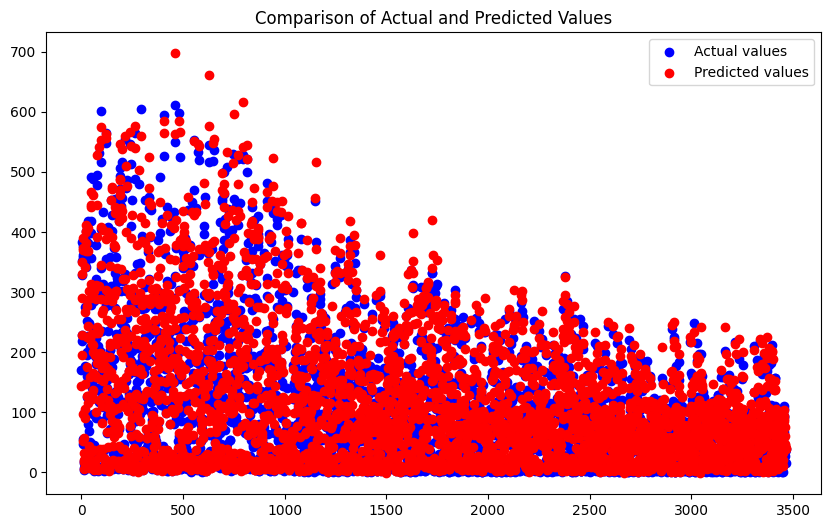

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



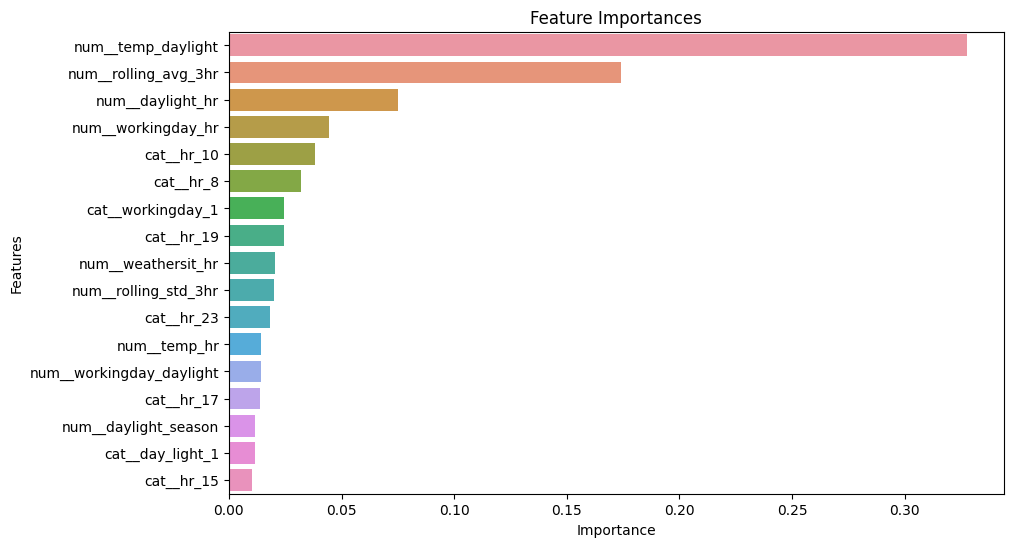

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

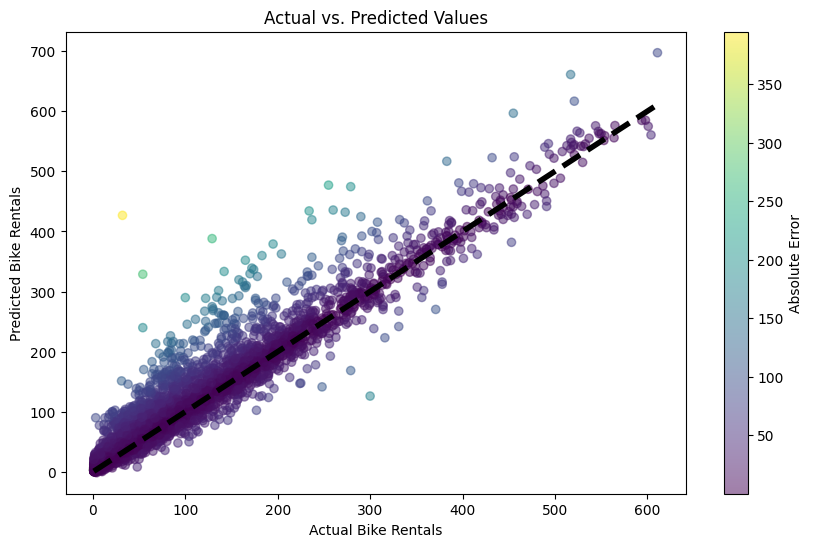

In [58]:
plt.figure(figsize=(10, 6))

# Create a color array based on the difference between actual and predicted values
color = np.abs(y_test - predictions)

# Scatter plot with colormap
scatter = plt.scatter(y_test, predictions, alpha=0.5, c=color, cmap='viridis')
plt.colorbar(scatter, label='Absolute Error')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.show()

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



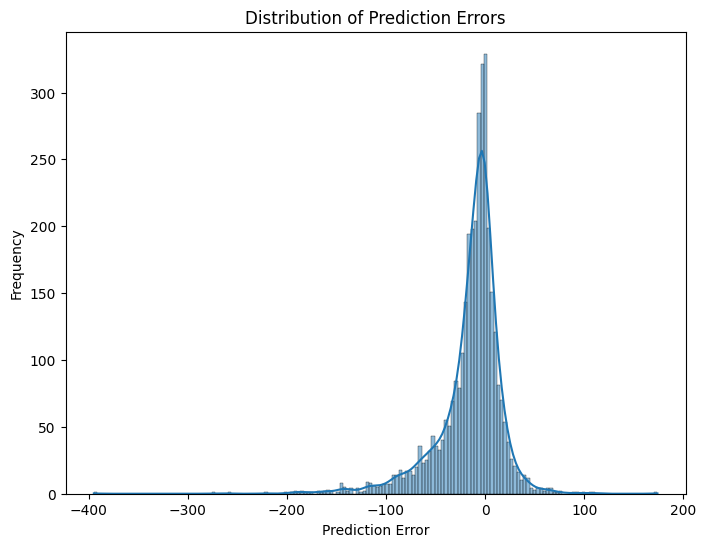

In [54]:
errors = y_test - predictions
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


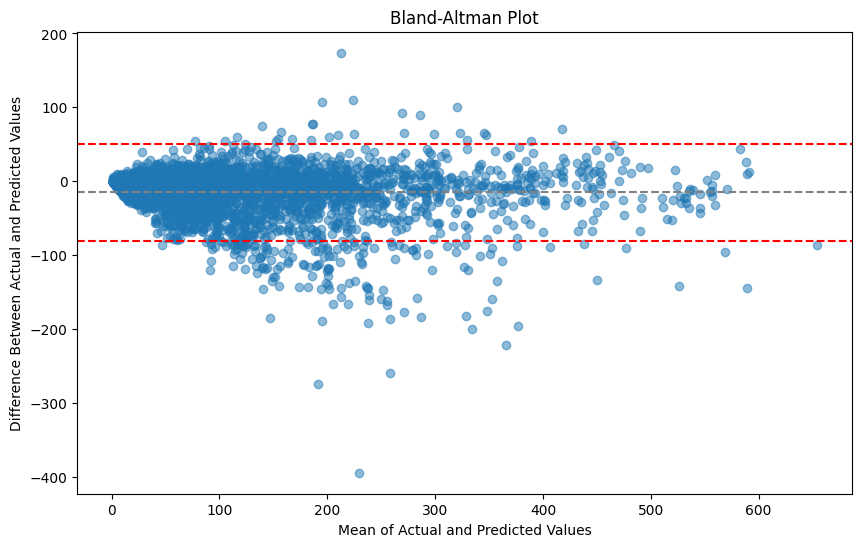

In [57]:
mean = np.mean([y_test, predictions], axis=0)
diff = y_test - predictions
md = np.mean(diff)
sd = np.std(diff, axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(mean, diff, alpha=0.5)
plt.axhline(md, color='gray', linestyle='--')
plt.axhline(md + 1.96 * sd, color='red', linestyle='--')
plt.axhline(md - 1.96 * sd, color='red', linestyle='--')
plt.title('Bland-Altman Plot')
plt.xlabel('Mean of Actual and Predicted Values')
plt.ylabel('Difference Between Actual and Predicted Values')
plt.show()


In [59]:
import plotly.express as px

fig = px.scatter(x=y_test, y=predictions, labels={'x': 'Actual Bike Rentals', 'y': 'Predicted Bike Rentals'},
                 title='Actual vs. Predicted Values')
fig.add_shape(type='line',
              x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max(),
              line=dict(color='Black', dash='dash'))
fig.update_layout(shapes=[dict(
    type='line', line=dict(dash='dash'),
    x0=y_test.min(), x1=y_test.max(),
    y0=y_test.min(), y1=y_test.max()
)])
fig.show()


In [60]:
import plotly.express as px

errors = y_test - predictions
fig = px.histogram(errors, nbins=50, labels={'value': 'Prediction Error'},
                   title='Distribution of Prediction Errors')
fig.update_layout(bargap=0.2)
fig.show()


In [62]:
mean = np.mean([y_test, predictions], axis=0)
diff = y_test - predictions
md = np.mean(diff)
sd = np.std(diff, axis=0)

fig = px.scatter(x=mean, y=diff, labels={'x': 'Mean of Actual and Predicted Values', 'y': 'Difference Between Actual and Predicted Values'},
                 title='Bland-Altman Plot')
fig.add_hline(y=md, line_dash="dash", line_color="grey")
fig.add_hline(y=md + 1.96 * sd, line_dash="dash", line_color="red")
fig.add_hline(y=md - 1.96 * sd, line_dash="dash", line_color="red")

fig.show()


## PART III: Streamlit dashboard

In [ ]:
### This part goes in a separate script ###